In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Umpire", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Umpire", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Umpire", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['Four', 'Leg_Bye', 'No_ball', 'Out', 'Six', 'Wide']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 1728
Total validation images: 468
Total test images: 585
Total images in dataset: 2781


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 1536
Validation images (excluding 'random_occlusion'): 416
Test images (excluding 'random_occlusion'): 520
Total images (excluding 'random_occlusion'): 2472


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'original', 'chromatic_aberration', 'gaussian_noise', 'blur', 'random_occlusion', 'motion_blur', 'low_resolution', 'lens_flare', 'dirty_lens'}
Validation folders considered: {'original', 'chromatic_aberration', 'gaussian_noise', 'blur', 'random_occlusion', 'motion_blur', 'low_resolution', 'lens_flare', 'dirty_lens'}
Test folders considered: {'original', 'chromatic_aberration', 'gaussian_noise', 'blur', 'random_occlusion', 'motion_blur', 'low_resolution', 'lens_flare', 'dirty_lens'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Umpire", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Umpire", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Umpire", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['Four', 'Leg_Bye', 'No_ball', 'Out', 'Six', 'Wide']
Final Training images: 1536
Final Validation images: 416
Final Test images: 520
Total images after filtering: 2472


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'original', 'chromatic_aberration', 'gaussian_noise', 'blur', 'motion_blur', 'low_resolution', 'lens_flare', 'dirty_lens'}
Validation folders considered: {'original', 'chromatic_aberration', 'gaussian_noise', 'blur', 'motion_blur', 'low_resolution', 'lens_flare', 'dirty_lens'}
Test folders considered: {'original', 'chromatic_aberration', 'gaussian_noise', 'blur', 'motion_blur', 'low_resolution', 'lens_flare', 'dirty_lens'}


In [7]:
# -----------------------------
# 2. Define Vision Transformer (ViT) Model from Scratch
# -----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import time
import math

class PatchEmbedding(nn.Module):
    """Patch Embedding Layer - Convert image to patches and embed them"""
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # Use Conv2d to create patch embeddings
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        # x shape: (B, C, H, W)
        x = self.proj(x)  # (B, embed_dim, H', W') where H' = H/patch_size, W' = W/patch_size
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

class MultiHeadAttention(nn.Module):
    """Multi-Head Self-Attention mechanism"""
    def __init__(self, embed_dim=768, n_heads=12, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads
        assert self.head_dim * n_heads == embed_dim, "embed_dim must be divisible by n_heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B, n_heads, N, head_dim)
        
        # Attention
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        
        return x

class MLP(nn.Module):
    """Multi-Layer Perceptron (Feed-Forward Network)"""
    def __init__(self, in_features, hidden_features=None, out_features=None, dropout=0.1):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    """Transformer Encoder Block"""
    def __init__(self, embed_dim=768, n_heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, n_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = MLP(embed_dim, mlp_hidden_dim, dropout=dropout)
        
    def forward(self, x):
        # Pre-norm architecture (Layer Norm before attention and MLP)
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class MyVisionTransformer(nn.Module):
    """Vision Transformer (ViT) Implementation from Scratch"""
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=4, 
                 embed_dim=768, depth=12, n_heads=12, mlp_ratio=4.0, dropout=0.1, 
                 emb_dropout=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.num_tokens = 1  # CLS token
        self.embed_dim = embed_dim
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.n_patches
        
        # CLS token and positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(emb_dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, n_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights"""
        # Initialize positional embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        # Initialize other weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
            elif isinstance(m, nn.Conv2d):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                    
    def forward(self, x):
        B = x.shape[0]
        
        # Create patch embeddings
        x = self.patch_embed(x)  # (B, n_patches, embed_dim)
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, n_patches + 1, embed_dim)
        
        # Add positional embeddings
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Final layer norm and classification
        x = self.norm(x)
        
        # Use CLS token for classification
        cls_token_final = x[:, 0]  # (B, embed_dim)
        x = self.head(cls_token_final)  # (B, num_classes)
        
        return x

In [8]:
# -----------------------------
# 3. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ViT-Base configuration
model = MyVisionTransformer(
    img_size=224,
    patch_size=16,
    in_channels=3,
    num_classes=len(classes),
    embed_dim=768,
    depth=12,
    n_heads=12,
    mlp_ratio=4.0,
    dropout=0.1,
    emb_dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.05)  # Lower LR for ViT

print("Vision Transformer (ViT) Model Summary:")
try:
    summary(model, (3, 224, 224))
except:
    print("Model summary generation failed - this is normal for complex architectures")
    print(f"Model created successfully with {sum(p.numel() for p in model.parameters()):,} parameters")

Vision Transformer (ViT) Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
    PatchEmbedding-2             [-1, 196, 768]               0
           Dropout-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6         [-1, 12, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8             [-1, 197, 768]               0
MultiHeadAttention-9             [-1, 197, 768]               0
        LayerNorm-10             [-1, 197, 768]           1,536
           Linear-11            [-1, 197, 3072]       2,362,368
             GELU-12            [-1, 197, 3072]               0
          Dropout-13            [-1, 197, 3072]               0


🚀 Starting Vision Transformer Training for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:06<00:00,  1.40s/it, Loss=1.6697, Acc=0.3086]


✅ Training completed in 66.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:08<00:00,  1.52it/s, Loss=2.0559, Acc=0.2812]


✅ Validation completed in 8.53s
🌟 New best Vision Transformer model found! Validation Accuracy: 0.2812

📊 Epoch 1 Summary:
│ Train Loss: 1.6697 | Train Acc: 0.3086
│ Val Loss:   2.0559 | Val Acc:   0.2812
│ Train Time: 66.98s | Val Time: 8.53s
│ Total Epoch Time: 75.51s
│ Best Val Acc: 0.2812 (Epoch 1)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6352, Acc=0.3275]


✅ Training completed in 63.42s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.88it/s, Loss=1.7576, Acc=0.3558]


✅ Validation completed in 6.90s
🌟 New best Vision Transformer model found! Validation Accuracy: 0.3558

📊 Epoch 2 Summary:
│ Train Loss: 1.6352 | Train Acc: 0.3275
│ Val Loss:   1.7576 | Val Acc:   0.3558
│ Train Time: 63.42s | Val Time: 6.90s
│ Total Epoch Time: 70.33s
│ Best Val Acc: 0.3558 (Epoch 2)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6336, Acc=0.3516]


✅ Training completed in 63.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.86it/s, Loss=1.8957, Acc=0.3221]


✅ Validation completed in 7.01s

📊 Epoch 3 Summary:
│ Train Loss: 1.6336 | Train Acc: 0.3516
│ Val Loss:   1.8957 | Val Acc:   0.3221
│ Train Time: 63.46s | Val Time: 7.01s
│ Total Epoch Time: 70.46s
│ Best Val Acc: 0.3558 (Epoch 2)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.31s/it, Loss=1.6568, Acc=0.3132]


✅ Training completed in 63.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.87it/s, Loss=1.5994, Acc=0.4062]


✅ Validation completed in 6.94s
🌟 New best Vision Transformer model found! Validation Accuracy: 0.4062

📊 Epoch 4 Summary:
│ Train Loss: 1.6568 | Train Acc: 0.3132
│ Val Loss:   1.5994 | Val Acc:   0.4062
│ Train Time: 63.07s | Val Time: 6.94s
│ Total Epoch Time: 70.02s
│ Best Val Acc: 0.4062 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6067, Acc=0.3307]


✅ Training completed in 63.16s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.85it/s, Loss=1.6119, Acc=0.3438]


✅ Validation completed in 7.03s

📊 Epoch 5 Summary:
│ Train Loss: 1.6067 | Train Acc: 0.3307
│ Val Loss:   1.6119 | Val Acc:   0.3438
│ Train Time: 63.16s | Val Time: 7.03s
│ Total Epoch Time: 70.19s
│ Best Val Acc: 0.4062 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6367, Acc=0.3314]


✅ Training completed in 63.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.82it/s, Loss=1.7218, Acc=0.2981]


✅ Validation completed in 7.15s

📊 Epoch 6 Summary:
│ Train Loss: 1.6367 | Train Acc: 0.3314
│ Val Loss:   1.7218 | Val Acc:   0.2981
│ Train Time: 63.18s | Val Time: 7.15s
│ Total Epoch Time: 70.33s
│ Best Val Acc: 0.4062 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.31s/it, Loss=1.6378, Acc=0.3255]


✅ Training completed in 63.08s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.87it/s, Loss=1.6351, Acc=0.3462]


✅ Validation completed in 6.97s

📊 Epoch 7 Summary:
│ Train Loss: 1.6378 | Train Acc: 0.3255
│ Val Loss:   1.6351 | Val Acc:   0.3462
│ Train Time: 63.08s | Val Time: 6.97s
│ Total Epoch Time: 70.05s
│ Best Val Acc: 0.4062 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6479, Acc=0.3255]


✅ Training completed in 63.27s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.87it/s, Loss=1.6098, Acc=0.3269]


✅ Validation completed in 6.97s

📊 Epoch 8 Summary:
│ Train Loss: 1.6479 | Train Acc: 0.3255
│ Val Loss:   1.6098 | Val Acc:   0.3269
│ Train Time: 63.27s | Val Time: 6.97s
│ Total Epoch Time: 70.24s
│ Best Val Acc: 0.4062 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6632, Acc=0.3066]


✅ Training completed in 63.25s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.84it/s, Loss=1.6467, Acc=0.2933]


✅ Validation completed in 7.07s

📊 Epoch 9 Summary:
│ Train Loss: 1.6632 | Train Acc: 0.3066
│ Val Loss:   1.6467 | Val Acc:   0.2933
│ Train Time: 63.25s | Val Time: 7.07s
│ Total Epoch Time: 70.33s
│ Best Val Acc: 0.4062 (Epoch 4)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.31s/it, Loss=1.6572, Acc=0.3177]


✅ Training completed in 63.09s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.86it/s, Loss=1.6508, Acc=0.4159]


✅ Validation completed in 7.00s
🌟 New best Vision Transformer model found! Validation Accuracy: 0.4159

📊 Epoch 10 Summary:
│ Train Loss: 1.6572 | Train Acc: 0.3177
│ Val Loss:   1.6508 | Val Acc:   0.4159
│ Train Time: 63.09s | Val Time: 7.00s
│ Total Epoch Time: 70.10s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.31s/it, Loss=1.6700, Acc=0.2962]


✅ Training completed in 63.04s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.86it/s, Loss=1.6486, Acc=0.3726]


✅ Validation completed in 7.01s

📊 Epoch 11 Summary:
│ Train Loss: 1.6700 | Train Acc: 0.2962
│ Val Loss:   1.6486 | Val Acc:   0.3726
│ Train Time: 63.04s | Val Time: 7.01s
│ Total Epoch Time: 70.05s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.31s/it, Loss=1.6688, Acc=0.3079]


✅ Training completed in 63.04s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.84it/s, Loss=1.6057, Acc=0.3125]


✅ Validation completed in 7.07s

📊 Epoch 12 Summary:
│ Train Loss: 1.6688 | Train Acc: 0.3079
│ Val Loss:   1.6057 | Val Acc:   0.3125
│ Train Time: 63.04s | Val Time: 7.07s
│ Total Epoch Time: 70.11s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.31s/it, Loss=1.6444, Acc=0.2969]


✅ Training completed in 63.05s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.87it/s, Loss=1.6187, Acc=0.3125]


✅ Validation completed in 6.97s

📊 Epoch 13 Summary:
│ Train Loss: 1.6444 | Train Acc: 0.2969
│ Val Loss:   1.6187 | Val Acc:   0.3125
│ Train Time: 63.05s | Val Time: 6.97s
│ Total Epoch Time: 70.02s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:02<00:00,  1.31s/it, Loss=1.6265, Acc=0.3079]


✅ Training completed in 62.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.86it/s, Loss=1.5944, Acc=0.3510]


✅ Validation completed in 6.97s

📊 Epoch 14 Summary:
│ Train Loss: 1.6265 | Train Acc: 0.3079
│ Val Loss:   1.5944 | Val Acc:   0.3510
│ Train Time: 62.98s | Val Time: 6.97s
│ Total Epoch Time: 69.95s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6290, Acc=0.3118]


✅ Training completed in 63.30s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.87it/s, Loss=1.7105, Acc=0.2332]


✅ Validation completed in 6.97s

📊 Epoch 15 Summary:
│ Train Loss: 1.6290 | Train Acc: 0.3118
│ Val Loss:   1.7105 | Val Acc:   0.2332
│ Train Time: 63.30s | Val Time: 6.97s
│ Total Epoch Time: 70.27s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6268, Acc=0.3229]


✅ Training completed in 63.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.85it/s, Loss=1.5918, Acc=0.3101]


✅ Validation completed in 7.04s

📊 Epoch 16 Summary:
│ Train Loss: 1.6268 | Train Acc: 0.3229
│ Val Loss:   1.5918 | Val Acc:   0.3101
│ Train Time: 63.22s | Val Time: 7.04s
│ Total Epoch Time: 70.26s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6374, Acc=0.3164]


✅ Training completed in 63.12s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.85it/s, Loss=1.6195, Acc=0.2788]


✅ Validation completed in 7.02s

📊 Epoch 17 Summary:
│ Train Loss: 1.6374 | Train Acc: 0.3164
│ Val Loss:   1.6195 | Val Acc:   0.2788
│ Train Time: 63.12s | Val Time: 7.02s
│ Total Epoch Time: 70.14s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6083, Acc=0.2982]


✅ Training completed in 63.24s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.87it/s, Loss=1.7525, Acc=0.2332]


✅ Validation completed in 6.95s

📊 Epoch 18 Summary:
│ Train Loss: 1.6083 | Train Acc: 0.2982
│ Val Loss:   1.7525 | Val Acc:   0.2332
│ Train Time: 63.24s | Val Time: 6.95s
│ Total Epoch Time: 70.19s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6248, Acc=0.2956]


✅ Training completed in 63.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.86it/s, Loss=1.6769, Acc=0.3462]


✅ Validation completed in 6.99s

📊 Epoch 19 Summary:
│ Train Loss: 1.6248 | Train Acc: 0.2956
│ Val Loss:   1.6769 | Val Acc:   0.3462
│ Train Time: 63.13s | Val Time: 6.99s
│ Total Epoch Time: 70.12s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.31s/it, Loss=1.6057, Acc=0.2969]


✅ Training completed in 63.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.86it/s, Loss=1.6040, Acc=0.2885]


✅ Validation completed in 6.98s

📊 Epoch 20 Summary:
│ Train Loss: 1.6057 | Train Acc: 0.2969
│ Val Loss:   1.6040 | Val Acc:   0.2885
│ Train Time: 63.07s | Val Time: 6.98s
│ Total Epoch Time: 70.05s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6035, Acc=0.3008]


✅ Training completed in 63.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.87it/s, Loss=1.6704, Acc=0.3101]


✅ Validation completed in 6.94s

📊 Epoch 21 Summary:
│ Train Loss: 1.6035 | Train Acc: 0.3008
│ Val Loss:   1.6704 | Val Acc:   0.3101
│ Train Time: 63.29s | Val Time: 6.94s
│ Total Epoch Time: 70.23s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.31s/it, Loss=1.6216, Acc=0.3053]


✅ Training completed in 63.03s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.86it/s, Loss=1.6438, Acc=0.3654]


✅ Validation completed in 6.98s

📊 Epoch 22 Summary:
│ Train Loss: 1.6216 | Train Acc: 0.3053
│ Val Loss:   1.6438 | Val Acc:   0.3654
│ Train Time: 63.03s | Val Time: 6.98s
│ Total Epoch Time: 70.02s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6058, Acc=0.3346]


✅ Training completed in 63.12s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.82it/s, Loss=1.6099, Acc=0.3245]


✅ Validation completed in 7.16s

📊 Epoch 23 Summary:
│ Train Loss: 1.6058 | Train Acc: 0.3346
│ Val Loss:   1.6099 | Val Acc:   0.3245
│ Train Time: 63.12s | Val Time: 7.16s
│ Total Epoch Time: 70.29s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.33s/it, Loss=1.6035, Acc=0.3184]


✅ Training completed in 63.74s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.83it/s, Loss=1.6480, Acc=0.3197]


✅ Validation completed in 7.10s

📊 Epoch 24 Summary:
│ Train Loss: 1.6035 | Train Acc: 0.3184
│ Val Loss:   1.6480 | Val Acc:   0.3197
│ Train Time: 63.74s | Val Time: 7.10s
│ Total Epoch Time: 70.84s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6019, Acc=0.3236]


✅ Training completed in 63.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.86it/s, Loss=1.6158, Acc=0.3221]


✅ Validation completed in 6.98s

📊 Epoch 25 Summary:
│ Train Loss: 1.6019 | Train Acc: 0.3236
│ Val Loss:   1.6158 | Val Acc:   0.3221
│ Train Time: 63.19s | Val Time: 6.98s
│ Total Epoch Time: 70.17s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6043, Acc=0.3184]


✅ Training completed in 63.15s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.84it/s, Loss=1.6171, Acc=0.3245]


✅ Validation completed in 7.06s

📊 Epoch 26 Summary:
│ Train Loss: 1.6043 | Train Acc: 0.3184
│ Val Loss:   1.6171 | Val Acc:   0.3245
│ Train Time: 63.15s | Val Time: 7.06s
│ Total Epoch Time: 70.22s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.5998, Acc=0.3190]


✅ Training completed in 63.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.86it/s, Loss=1.6344, Acc=0.2692]


✅ Validation completed in 6.98s

📊 Epoch 27 Summary:
│ Train Loss: 1.5998 | Train Acc: 0.3190
│ Val Loss:   1.6344 | Val Acc:   0.2692
│ Train Time: 63.18s | Val Time: 6.98s
│ Total Epoch Time: 70.16s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6188, Acc=0.3223]


✅ Training completed in 63.16s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.87it/s, Loss=1.6220, Acc=0.3029]


✅ Validation completed in 6.97s

📊 Epoch 28 Summary:
│ Train Loss: 1.6188 | Train Acc: 0.3223
│ Val Loss:   1.6220 | Val Acc:   0.3029
│ Train Time: 63.16s | Val Time: 6.97s
│ Total Epoch Time: 70.13s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6145, Acc=0.3164]


✅ Training completed in 63.21s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.86it/s, Loss=1.6438, Acc=0.3582]


✅ Validation completed in 7.00s

📊 Epoch 29 Summary:
│ Train Loss: 1.6145 | Train Acc: 0.3164
│ Val Loss:   1.6438 | Val Acc:   0.3582
│ Train Time: 63.21s | Val Time: 7.00s
│ Total Epoch Time: 70.21s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6051, Acc=0.3190]


✅ Training completed in 63.14s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.85it/s, Loss=1.6428, Acc=0.2788]


✅ Validation completed in 7.05s

📊 Epoch 30 Summary:
│ Train Loss: 1.6051 | Train Acc: 0.3190
│ Val Loss:   1.6428 | Val Acc:   0.2788
│ Train Time: 63.14s | Val Time: 7.05s
│ Total Epoch Time: 70.19s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.31s/it, Loss=1.6085, Acc=0.3327]


✅ Training completed in 63.12s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.88it/s, Loss=1.6321, Acc=0.3101]


✅ Validation completed in 6.91s

📊 Epoch 31 Summary:
│ Train Loss: 1.6085 | Train Acc: 0.3327
│ Val Loss:   1.6321 | Val Acc:   0.3101
│ Train Time: 63.12s | Val Time: 6.91s
│ Total Epoch Time: 70.03s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.5989, Acc=0.3053]


✅ Training completed in 63.20s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.83it/s, Loss=1.6171, Acc=0.3486]


✅ Validation completed in 7.10s

📊 Epoch 32 Summary:
│ Train Loss: 1.5989 | Train Acc: 0.3053
│ Val Loss:   1.6171 | Val Acc:   0.3486
│ Train Time: 63.20s | Val Time: 7.10s
│ Total Epoch Time: 70.30s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.6018, Acc=0.3288]


✅ Training completed in 63.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.86it/s, Loss=1.6508, Acc=0.2981]


✅ Validation completed in 6.98s

📊 Epoch 33 Summary:
│ Train Loss: 1.6018 | Train Acc: 0.3288
│ Val Loss:   1.6508 | Val Acc:   0.2981
│ Train Time: 63.19s | Val Time: 6.98s
│ Total Epoch Time: 70.17s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.31s/it, Loss=1.5818, Acc=0.3561]


✅ Training completed in 63.11s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.87it/s, Loss=1.5969, Acc=0.3293]


✅ Validation completed in 6.95s

📊 Epoch 34 Summary:
│ Train Loss: 1.5818 | Train Acc: 0.3561
│ Val Loss:   1.5969 | Val Acc:   0.3293
│ Train Time: 63.11s | Val Time: 6.95s
│ Total Epoch Time: 70.06s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.5905, Acc=0.3470]


✅ Training completed in 63.39s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.82it/s, Loss=1.6255, Acc=0.3438]


✅ Validation completed in 7.14s

📊 Epoch 35 Summary:
│ Train Loss: 1.5905 | Train Acc: 0.3470
│ Val Loss:   1.6255 | Val Acc:   0.3438
│ Train Time: 63.39s | Val Time: 7.14s
│ Total Epoch Time: 70.53s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.5903, Acc=0.3203]


✅ Training completed in 63.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.86it/s, Loss=1.7106, Acc=0.2067]


✅ Validation completed in 6.97s

📊 Epoch 36 Summary:
│ Train Loss: 1.5903 | Train Acc: 0.3203
│ Val Loss:   1.7106 | Val Acc:   0.2067
│ Train Time: 63.19s | Val Time: 6.97s
│ Total Epoch Time: 70.16s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.5934, Acc=0.3242]


✅ Training completed in 63.28s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.88it/s, Loss=1.5928, Acc=0.3389]


✅ Validation completed in 6.91s

📊 Epoch 37 Summary:
│ Train Loss: 1.5934 | Train Acc: 0.3242
│ Val Loss:   1.5928 | Val Acc:   0.3389
│ Train Time: 63.28s | Val Time: 6.91s
│ Total Epoch Time: 70.20s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.31s/it, Loss=1.5830, Acc=0.3405]


✅ Training completed in 63.12s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.84it/s, Loss=1.5893, Acc=0.3125]


✅ Validation completed in 7.08s

📊 Epoch 38 Summary:
│ Train Loss: 1.5830 | Train Acc: 0.3405
│ Val Loss:   1.5893 | Val Acc:   0.3125
│ Train Time: 63.12s | Val Time: 7.08s
│ Total Epoch Time: 70.21s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.33s/it, Loss=1.5819, Acc=0.3392]


✅ Training completed in 63.78s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.84it/s, Loss=1.6474, Acc=0.2981]


✅ Validation completed in 7.07s

📊 Epoch 39 Summary:
│ Train Loss: 1.5819 | Train Acc: 0.3392
│ Val Loss:   1.6474 | Val Acc:   0.2981
│ Train Time: 63.78s | Val Time: 7.07s
│ Total Epoch Time: 70.86s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:02<00:00,  1.31s/it, Loss=1.5854, Acc=0.3477]


✅ Training completed in 63.00s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.86it/s, Loss=1.5982, Acc=0.3534]


✅ Validation completed in 6.97s

📊 Epoch 40 Summary:
│ Train Loss: 1.5854 | Train Acc: 0.3477
│ Val Loss:   1.5982 | Val Acc:   0.3534
│ Train Time: 63.00s | Val Time: 6.97s
│ Total Epoch Time: 69.98s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.5814, Acc=0.3398]


✅ Training completed in 63.21s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.85it/s, Loss=1.6111, Acc=0.3029]


✅ Validation completed in 7.04s

📊 Epoch 41 Summary:
│ Train Loss: 1.5814 | Train Acc: 0.3398
│ Val Loss:   1.6111 | Val Acc:   0.3029
│ Train Time: 63.21s | Val Time: 7.04s
│ Total Epoch Time: 70.26s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.31s/it, Loss=1.5867, Acc=0.3262]


✅ Training completed in 63.03s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.88it/s, Loss=1.6355, Acc=0.2933]


✅ Validation completed in 6.91s

📊 Epoch 42 Summary:
│ Train Loss: 1.5867 | Train Acc: 0.3262
│ Val Loss:   1.6355 | Val Acc:   0.2933
│ Train Time: 63.03s | Val Time: 6.91s
│ Total Epoch Time: 69.94s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.5992, Acc=0.3216]


✅ Training completed in 63.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.86it/s, Loss=1.5782, Acc=0.3365]


✅ Validation completed in 7.00s

📊 Epoch 43 Summary:
│ Train Loss: 1.5992 | Train Acc: 0.3216
│ Val Loss:   1.5782 | Val Acc:   0.3365
│ Train Time: 63.22s | Val Time: 7.00s
│ Total Epoch Time: 70.22s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.5781, Acc=0.3385]


✅ Training completed in 63.17s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.84it/s, Loss=1.5966, Acc=0.2981]


✅ Validation completed in 7.08s

📊 Epoch 44 Summary:
│ Train Loss: 1.5781 | Train Acc: 0.3385
│ Val Loss:   1.5966 | Val Acc:   0.2981
│ Train Time: 63.17s | Val Time: 7.08s
│ Total Epoch Time: 70.25s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.5726, Acc=0.3535]


✅ Training completed in 63.32s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.88it/s, Loss=1.6042, Acc=0.2957]


✅ Validation completed in 6.90s

📊 Epoch 45 Summary:
│ Train Loss: 1.5726 | Train Acc: 0.3535
│ Val Loss:   1.6042 | Val Acc:   0.2957
│ Train Time: 63.32s | Val Time: 6.90s
│ Total Epoch Time: 70.23s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.5707, Acc=0.3561]


✅ Training completed in 63.15s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.87it/s, Loss=1.6214, Acc=0.3101]


✅ Validation completed in 6.96s

📊 Epoch 46 Summary:
│ Train Loss: 1.5707 | Train Acc: 0.3561
│ Val Loss:   1.6214 | Val Acc:   0.3101
│ Train Time: 63.15s | Val Time: 6.96s
│ Total Epoch Time: 70.11s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.5737, Acc=0.3600]


✅ Training completed in 63.32s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.85it/s, Loss=1.6090, Acc=0.3077]


✅ Validation completed in 7.04s

📊 Epoch 47 Summary:
│ Train Loss: 1.5737 | Train Acc: 0.3600
│ Val Loss:   1.6090 | Val Acc:   0.3077
│ Train Time: 63.32s | Val Time: 7.04s
│ Total Epoch Time: 70.36s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.5681, Acc=0.3438]


✅ Training completed in 63.21s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.86it/s, Loss=1.6552, Acc=0.2933]


✅ Validation completed in 6.99s

📊 Epoch 48 Summary:
│ Train Loss: 1.5681 | Train Acc: 0.3438
│ Val Loss:   1.6552 | Val Acc:   0.2933
│ Train Time: 63.21s | Val Time: 6.99s
│ Total Epoch Time: 70.21s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.31s/it, Loss=1.5747, Acc=0.3366]


✅ Training completed in 63.04s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.88it/s, Loss=1.6104, Acc=0.3245]


✅ Validation completed in 6.93s

📊 Epoch 49 Summary:
│ Train Loss: 1.5747 | Train Acc: 0.3366
│ Val Loss:   1.6104 | Val Acc:   0.3245
│ Train Time: 63.04s | Val Time: 6.93s
│ Total Epoch Time: 69.97s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.32s/it, Loss=1.5651, Acc=0.3431]


✅ Training completed in 63.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:06<00:00,  1.88it/s, Loss=1.6038, Acc=0.3149]


✅ Validation completed in 6.92s

📊 Epoch 50 Summary:
│ Train Loss: 1.5651 | Train Acc: 0.3431
│ Val Loss:   1.6038 | Val Acc:   0.3149
│ Train Time: 63.13s | Val Time: 6.92s
│ Total Epoch Time: 70.05s
│ Best Val Acc: 0.4159 (Epoch 10)
│ GPU Memory: 1.3GB / 6.7GB

💾 Best Vision Transformer model saved as 'best_vit_model.pth'
📊 Best model stats:
│ Best Epoch: 10
│ Best Val Acc: 0.4159

💾 Vision Transformer training history saved to 'vit_training_history.csv'

🎉 Vision Transformer Training Complete!
Total Training Time: 3515.30s (58.6 minutes)
Average Epoch Time: 70.31s

⏱️  Epoch Timing Breakdown:
│ Epoch 1: 75.51s
│ Epoch 2: 70.33s
│ Epoch 3: 70.46s
│ Epoch 4: 70.02s
│ Epoch 5: 70.19s
│ Epoch 6: 70.33s
│ Epoch 7: 70.05s
│ Epoch 8: 70.24s
│ Epoch 9: 70.33s
│ Epoch 10: 70.10s
│ Epoch 11: 70.05s
│ Epoch 12: 70.11s
│ Epoch 13: 70.02s
│ Epoch 14: 69.95s
│ Epoch 15: 70.27s
│ Epoch 16: 70.26s
│ Epoch 17: 70.14s
│ Epoch 18: 70.19s
│ Epoch 19: 70.12s
│ Epoch 20: 70.05s
│ Epoch 21: 70.23s
│ Epoch

Testing Vision Transformer: 100%|██████████████████████████████| 17/17 [00:11<00:00,  1.47it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

✅ Vision Transformer Testing completed in 11.54s

📋 Vision Transformer Classification Report:
              precision    recall  f1-score   support

        Four       0.00      0.00      0.00        40
     Leg_Bye       0.00      0.00      0.00        40
     No_ball       0.12      0.01      0.02       104
         Out       0.00      0.00      0.00        48
         Six       0.33      0.51      0.41       152
        Wide       0.27      0.55      0.36       136

    accuracy                           0.30       520
   macro avg       0.12      0.18      0.13       520
weighted avg       0.19      0.30      0.22       520

🎯 Vision Transformer Test Accuracy: 0.2962

📊 Vision Transformer Model Performance Summary:
│ Best Validation Acc:  0.4159 (Epoch 10)
│ Final Test Accuracy:  0.2962
│ Val-Test Gap:         0.1197


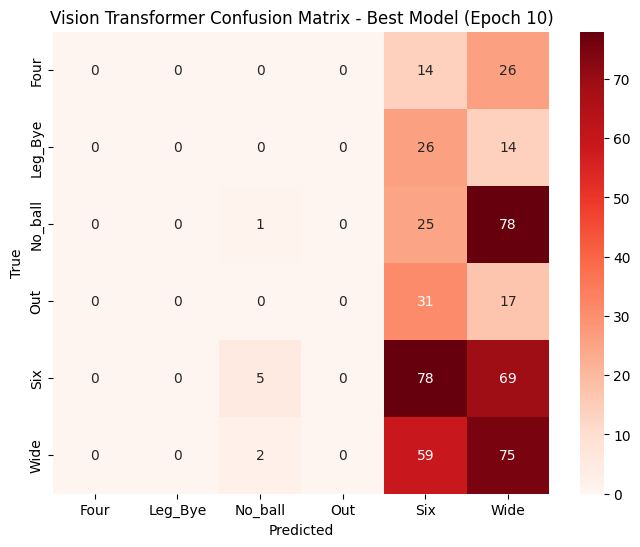

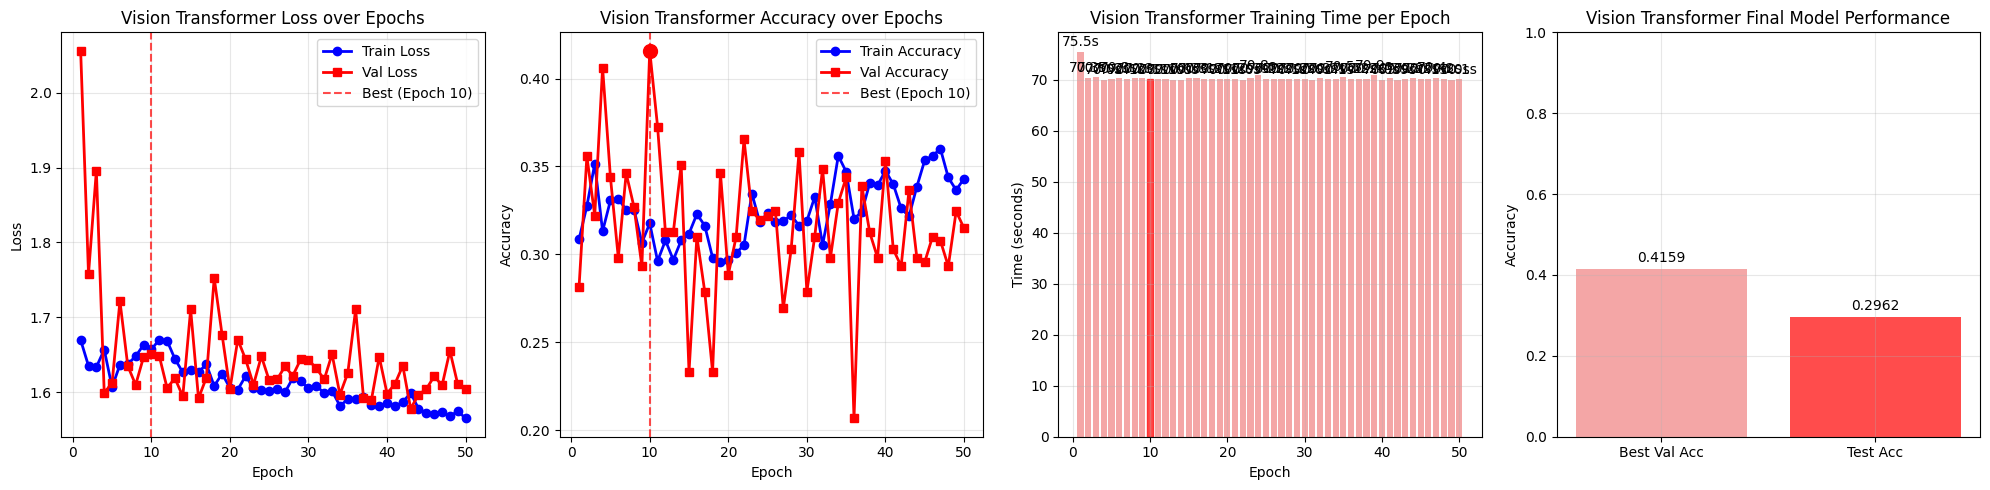


⏰ Vision Transformer Final Timing Summary:
│ Total Training: 3515.30s
│ Average per Epoch: 70.31s
│ Testing Time: 11.54s
│ Total Runtime: 3526.85s

💾 Vision Transformer Files saved:
│ best_vit_model.pth - Best validation accuracy model
│ vit_training_history.csv - Training metrics for later plotting

🏗️  Vision Transformer Architecture Summary:
│ Total Parameters: 85,803,270
│ Trainable Parameters: 85,803,270
│ Model Size: 327.31 MB
│ Input Size: 224x224x3
│ Patch Size: 16x16
│ Number of Patches: 196
│ Embed Dimension: 768
│ Number of Heads: 12
│ Number of Layers: 12
│ MLP Ratio: 4.0
│ Output Classes: 6
│ Activation: GELU
│ Attention Dropout: 0.1
│ Embedding Dropout: 0.1


In [9]:
# -----------------------------
# 4. Training Loop with Best Model Saving (Val Accuracy) - Vision Transformer
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking
best_val_acc = 0.0
best_model_state = None
best_epoch = 0

print(f"\n🚀 Starting Vision Transformer Training for {epochs} epochs...")
print("=" * 80)

total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc=f"Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model so far based on val_acc
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best Vision Transformer model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_vit_model.pth')
    print(f"\n💾 Best Vision Transformer model saved as 'best_vit_model.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")

# Save training history data to CSV
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}
history_df = pd.DataFrame(history_data)
history_df.to_csv('vit_training_history.csv', index=False)
print("\n💾 Vision Transformer training history saved to 'vit_training_history.csv'")

# Training Summary
print(f"\n🎉 Vision Transformer Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")
print("\n⏱️  Epoch Timing Breakdown:")
for i, t in enumerate(epoch_times):
    print(f"│ Epoch {i+1}: {t:.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best Vision Transformer Model for Testing...")

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best Vision Transformer model from epoch {best_epoch} loaded successfully!")
else:
    print("⚠️  No best model found, using current model state")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()

test_pbar = tqdm(test_loader, desc="Testing Vision Transformer", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ Vision Transformer Testing completed in {test_time:.2f}s")
print("\n📋 Vision Transformer Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 Vision Transformer Test Accuracy: {test_accuracy:.4f}")

# Model Performance Summary
print(f"\n📊 Vision Transformer Model Performance Summary:")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Vision Transformer Confusion Matrix - Best Model (Epoch {best_epoch})")
plt.show()

# -----------------------------
# 6. Enhanced Visualizations
# -----------------------------
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.legend()
plt.title("Vision Transformer Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='red', s=100, zorder=5)
plt.legend()
plt.title("Vision Transformer Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
bars = plt.bar(range(1, epochs+1), epoch_times, color='lightcoral', alpha=0.7)
bars[best_epoch-1].set_color('red')
plt.title("Vision Transformer Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
for i, t in enumerate(epoch_times):
    plt.text(i+1, t+0.5, f'{t:.1f}s', ha='center', va='bottom')

# Performance Comparison
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['lightcoral', 'red']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("Vision Transformer Final Model Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n⏰ Vision Transformer Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

print(f"\n💾 Vision Transformer Files saved:")
print(f"│ best_vit_model.pth - Best validation accuracy model")
print(f"│ vit_training_history.csv - Training metrics for later plotting")

# -----------------------------
# 7. Vision Transformer Architecture Summary
# -----------------------------
print(f"\n🏗️  Vision Transformer Architecture Summary:")
print(f"│ Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"│ Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"│ Model Size: {sum(p.numel() * p.element_size() for p in model.parameters()) / 1024**2:.2f} MB")
print(f"│ Input Size: 224x224x3")
print(f"│ Patch Size: 16x16")
print(f"│ Number of Patches: {model.patch_embed.n_patches}")
print(f"│ Embed Dimension: {model.embed_dim}")
print(f"│ Number of Heads: 12")
print(f"│ Number of Layers: 12")
print(f"│ MLP Ratio: 4.0")
print(f"│ Output Classes: {len(classes)}")
print(f"│ Activation: GELU")
print(f"│ Attention Dropout: 0.1")
print(f"│ Embedding Dropout: 0.1")
